In [2]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

import math

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12

cmap = GreenOrange_12.hex_colors

In [4]:
import hightolowz

from protocluster_completeness_purity import cluster_stats

In [15]:
L = 480.279

In [41]:
gals_z6p42_sfr = pd.read_csv('data/henriques2015a_z6p42_sfr.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z5p03_sfr = pd.read_csv('data/henriques2015a_z5p03_sfr.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z3p95_sfr = pd.read_csv('data/henriques2015a_z3p95_sfr.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z3p10_sfr = pd.read_csv('data/henriques2015a_z3p10_sfr.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z2p07_sfr = pd.read_csv('data/henriques2015a_z2p07_sfr.csv', 
                               skiprows=111, skipfooter=1, engine='python')

In [42]:
gals_z6p42_mstar = pd.read_csv('data/henriques2015a_z6p42_mstar.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z5p03_mstar = pd.read_csv('data/henriques2015a_z5p03_mstar.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z3p95_mstar = pd.read_csv('data/henriques2015a_z3p95_mstar.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z3p10_mstar = pd.read_csv('data/henriques2015a_z3p10_mstar.csv', 
                               skiprows=104, skipfooter=1, engine='python')

gals_z2p07_mstar = pd.read_csv('data/henriques2015a_z2p07_mstar.csv', 
                               skiprows=104, skipfooter=1, engine='python')

### Mass functions of galaxy selections

[  6.8   7.2   7.6   8.    8.4   8.8   9.2   9.6  10.   10.4  10.8  11.2
  11.6  12.   12.4  12.8] [  7.    7.4   7.8   8.2   8.6   9.    9.4   9.8  10.2  10.6  11.   11.4
  11.8  12.2  12.6]


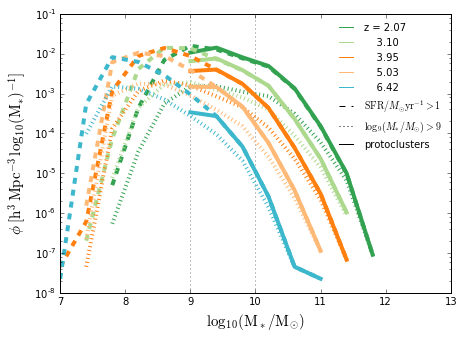

In [62]:
binLimits = np.linspace(6.8, 12.8, 16)
bins = np.linspace(7, 12.6, 15)

print binLimits, bins

fig, ax = plt.subplots(figsize=(7,5))


galaxy_data = [gals_z2p07_mstar, gals_z2p07_sfr,
               gals_z3p10_mstar, gals_z3p10_sfr,
               gals_z3p95_mstar, gals_z3p95_sfr,
               gals_z5p03_mstar, gals_z5p03_sfr,
               gals_z6p42_mstar, gals_z6p42_sfr]

zees = ['2p07','','3p10','','3p95','','5p03','','6p42','']

for i, (gals, z) in enumerate(zip(galaxy_data,zees)):

    phi, dummy = np.histogram(np.log10(gals['zn_stellarMass'] * 1e10), bins=binLimits)
    phi = (phi / L**3) / (binLimits[1] - binLimits[0])
    
    if (i % 2) == 0:
        ax.semilogy(bins, phi, c=cmap[i/2], label=z, linewidth=4)
        
    else:
        ax.semilogy(bins, phi, c=cmap[i/2], label=z, linestyle='dashed', linewidth=4)
        
        phi, dummy = np.histogram(np.log10(gals.loc[gals['z0_central_mcrit200'] > 1e4]['zn_stellarMass'] * 1e10), bins=binLimits)
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])
        ax.semilogy(bins, phi, c=cmap[i/2], linestyle='dotted', linewidth=4)


ax.set_xlabel("$\\rm{log_{10}}(M_* / M_{\odot})$", size=15)
ax.set_ylabel("$\phi \; [\\mathrm{h^{3} \, Mpc^{-3} \, log_{10}(M_{*})^{-1}}]$", size=15)

ax.set_xlim(7, 13)
ax.set_ylim(1e-8, 1e-1)

ax.vlines(10, 1e-9, 1e-1, linestyle='dotted', color='grey')
ax.vlines(9, 1e-9, 1e-1, linestyle='dotted', color='grey')

# ax.legend(prop={'size':10}, frameon=False)


line_z = []
for i in range(len(['2p07','3p10','3p95','5p03','6p42'])):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

line_sfr = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
line_mstar = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')
line_pcs = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')

ax.legend(handles=[line_z[0], line_z[1], line_z[2],
                   line_z[3], line_z[4],
                   line_sfr, line_mstar, line_pcs], 
           labels=['z = 2.07','    3.10','    3.95','    5.03','    6.42',
                   '$\mathrm{SFR} / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{9}}(M_{*} / M_{\odot}) > 9$',
                  'protoclusters'], 
           prop={'size':10}, frameon=False) # bbox_to_anchor=(1, -0.2),

# fig.savefig('../papers/hightolowz/images/gsmf.png', dpi=300, bbox_inches='tight')

### Completeness and Purity

In [10]:
# cstats_z2p07_sfr = cluster_stats(gals_z2p07_sfr, L)
# cstats_z3p10_sfr = cluster_stats(gals_z3p10_sfr, L)
# cstats_z3p95_sfr = cluster_stats(gals_z3p95_sfr, L)
# cstats_z5p03_sfr = cluster_stats(gals_z5p03_sfr, L)
# cstats_z6p42_sfr = cluster_stats(gals_z6p42_sfr, L)

# cstats_z2p07_mstar9 = cluster_stats(gals_z2p07_mstar, L)
# cstats_z3p10_mstar9 = cluster_stats(gals_z3p10_mstar, L)
# cstats_z3p95_mstar9 = cluster_stats(gals_z3p95_mstar, L)
# cstats_z5p03_mstar9 = cluster_stats(gals_z5p03_mstar, L)
# cstats_z6p42_mstar9 = cluster_stats(gals_z6p42_mstar, L)

# cstats_z2p07_mstar10 = cluster_stats(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1], L)
# cstats_z3p10_mstar10 = cluster_stats(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1], L)
# cstats_z3p95_mstar10 = cluster_stats(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1], L)
# cstats_z5p03_mstar10 = cluster_stats(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1], L)
# cstats_z6p42_mstar10 = cluster_stats(gals_z6p42_mstar.loc[gals_z6p42_mstar['zn_stellarMass'] > 1], L)

# pcl.dump([cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr,
#           cstats_z2p07_mstar9, cstats_z3p10_mstar9, cstats_z3p95_mstar9, cstats_z5p03_mstar9, cstats_z6p42_mstar9,
#           cstats_z2p07_mstar10, cstats_z3p10_mstar10, cstats_z3p95_mstar10, cstats_z5p03_mstar10, cstats_z6p42_mstar10], 
#           open('data/clustering_stats.p','wb'))

In [5]:
cstats = pcl.load(open('data/clustering_stats.p', 'rb'))

cstats_z2p07_sfr = cstats[0]
cstats_z3p10_sfr = cstats[1]
cstats_z3p95_sfr = cstats[2]
cstats_z5p03_sfr = cstats[3]
cstats_z6p42_sfr = cstats[4]
cstats_z2p07_mstar9 = cstats[5]
cstats_z3p10_mstar9 = cstats[6]
cstats_z3p95_mstar9 = cstats[7]
cstats_z5p03_mstar9 = cstats[8]
cstats_z6p42_mstar9 = cstats[9]
cstats_z2p07_mstar10 = cstats[10]
cstats_z3p10_mstar10 = cstats[11]
cstats_z3p95_mstar10 = cstats[12]
cstats_z5p03_mstar10 = cstats[13]
cstats_z6p42_mstar10 = cstats[14]

/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


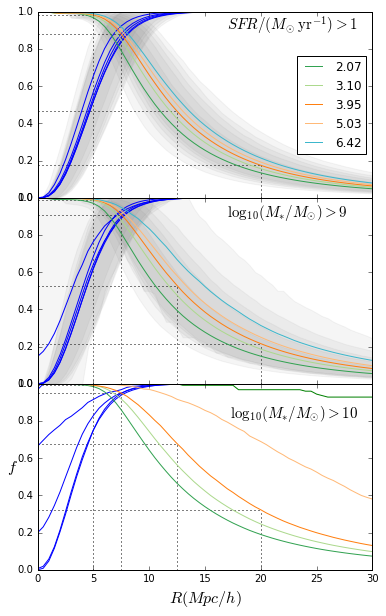

In [6]:
fig = plt.figure(figsize=(6,10))

gs = gridspec.GridSpec(3, 1)

gs.update(hspace=0)#, wspace=0) bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

rangex = [float(x)/2 for x in range(61)]

for cstat in [cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr]:
    ax1.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
                     cstat['completeness_percentiles'][:,1], alpha=0.08, color='grey')
    
    ax1.fill_between(rangex, cstat['purity_percentiles'][:,0], 
                     cstat['purity_percentiles'][:,1], alpha=0.08, color='grey')

ax1.plot(rangex, np.mean([x[0] for x in cstats_z2p07_sfr['cstats']], axis=0), c='blue')
ax1.plot(rangex, np.mean([x[0] for x in cstats_z3p10_sfr['cstats']], axis=0), c='blue')
ax1.plot(rangex, np.mean([x[0] for x in cstats_z3p95_sfr['cstats']], axis=0), c='blue')
ax1.plot(rangex, np.mean([x[0] for x in cstats_z5p03_sfr['cstats']], axis=0), c='blue')
ax1.plot(rangex, np.mean([x[0] for x in cstats_z6p42_sfr['cstats']], axis=0), c='blue')

ax1.plot(rangex,np.ma.masked_where([x[1] for x in cstats_z2p07_sfr['cstats'] if x[1]] == 0, 
                   np.mean([x[1] for x in cstats_z2p07_sfr['cstats'] if x[1]], axis=0)), c=cmap[0], label='2.07')

ax1.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p10_sfr['cstats'] if x[1]] == 0, 
                   np.mean([x[1] for x in cstats_z3p10_sfr['cstats'] if x[1]], axis=0)), c=cmap[1], label='3.10')

ax1.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p95_sfr['cstats'] if x[1]] == 0, 
                   np.mean([x[1] for x in cstats_z3p95_sfr['cstats'] if x[1]], axis=0)), c=cmap[2], label='3.95')

ax1.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z5p03_sfr['cstats'] if x[1]] == 0, 
                   np.mean([x[1] for x in cstats_z5p03_sfr['cstats'] if x[1]], axis=0)), c=cmap[3], label='5.03')

ax1.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z6p42_sfr['cstats'] if x[1]] == 0, 
                    np.mean([x[1] for x in cstats_z6p42_sfr['cstats'] if x[1]], axis=0)), c=cmap[4], label='6.42')


ax1.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], 
           linestyle='dotted')

ax1.hlines(np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], 
           linestyle='dotted')

#ax1.axvspan(6.7, 8.1, color='y', alpha=0.5, lw=0)

ax1.legend(loc='center right')

ax1.text(17, 0.9, "$SFR / (M_{\odot} \; \mathrm{yr}^{-1}) > 1$", size=15)

ax1.set_xlabel('$R (Mpc / h)$', size=16)
#ax1.set_ylabel('$f$', rotation=0, size=16)

ax1.set_xticklabels('')


#### Plot 2

for cstat in [cstats_z2p07_mstar9, cstats_z3p10_mstar9, cstats_z3p95_mstar9, cstats_z5p03_mstar9, cstats_z6p42_mstar9]:
    ax2.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
                     cstat['completeness_percentiles'][:,1], alpha=0.08, color='grey')
    
    ax2.fill_between(rangex, cstat['purity_percentiles'][:,0], 
                     cstat['purity_percentiles'][:,1], alpha=0.08, color='grey')

ax2.plot(rangex, np.mean([x[0] for x in cstats_z2p07_mstar9['cstats']], axis=0), c='blue')
ax2.plot(rangex, np.mean([x[0] for x in cstats_z3p10_mstar9['cstats']], axis=0), c='blue')
ax2.plot(rangex, np.mean([x[0] for x in cstats_z3p95_mstar9['cstats']], axis=0), c='blue')
ax2.plot(rangex, np.mean([x[0] for x in cstats_z5p03_mstar9['cstats']], axis=0), c='blue')
ax2.plot(rangex, np.mean([x[0] for x in cstats_z6p42_mstar9['cstats']], axis=0), c='blue')

ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z2p07_mstar9['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstats_z2p07_mstar9['cstats'] if x[1]])).mean(axis=0), c=cmap[0], label='2p07')
ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p10_mstar9['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstats_z3p10_mstar9['cstats'] if x[1]])).mean(axis=0), c=cmap[1], label='3p10')
ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p95_mstar9['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstats_z3p95_mstar9['cstats'] if x[1]])).mean(axis=0), c=cmap[2], label='3p95')
ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z5p03_mstar9['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstats_z5p03_mstar9['cstats'] if x[1]])).mean(axis=0), c=cmap[3], label='5p03')
ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z6p42_mstar9['cstats'] if x[1]] == 0, 
                    np.vstack([x[1] for x in cstats_z6p42_mstar9['cstats'] if x[1]])).mean(axis=0), c=cmap[4], label='6p42')
'cstats'
ax2.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_mstar9['cstats']], axis=0)[[10, 15, 25, 40]], 
           linestyle='dotted')

ax2.hlines(np.mean([x[1] for x in cstats_z3p95_mstar9['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], 
           linestyle='dotted')

#ax2.axvspan(6.7, 8.1, color='y', alpha=0.5, lw=0)

ax2.text(17, 0.9, "$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$", size=15)

ax2.set_xlabel('$R (Mpc / h)$', size=16)
#ax2.set_ylabel('$f$', rotation=0, size=16)

ax2.set_xticklabels('')


#### Plot 3

# for cstat in [cstats_z2p07_mstar10, cstats_z3p10_mstar10, cstats_z3p95_mstar10, cstats_z5p03_mstar10, cstats_z6p42_mstar10]:
#     ax3.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
#                      cstat['completeness_percentiles'][:,1], alpha=0.1, color='grey')
    
#     ax3.fill_between(rangex, cstat['purity_percentiles'][:,0], 
#                      cstat['purity_percentiles'][:,1], alpha=0.1, color='grey')

ax3.plot(rangex, np.mean([x[0] for x in cstats_z2p07_mstar10['cstats']], axis=0), c='blue')
ax3.plot(rangex, np.mean([x[0] for x in cstats_z3p10_mstar10['cstats']], axis=0), c='blue')
ax3.plot(rangex, np.mean([x[0] for x in cstats_z3p95_mstar10['cstats']], axis=0), c='blue')
ax3.plot(rangex, np.mean([x[0] for x in cstats_z5p03_mstar10['cstats']], axis=0), c='blue')
ax3.plot(rangex, np.mean([x[0] for x in cstats_z6p42_mstar10['cstats']], axis=0), c='blue')

ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z2p07_mstar10['cstats'] if x[1]]==0, 
                    [x[1] for x in cstats_z2p07_mstar10['cstats'] if x[1]]).mean(axis=0), cmap[0])
ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p10_mstar10['cstats'] if x[1]]==0, 
                    [x[1] for x in cstats_z3p10_mstar10['cstats'] if x[1]]).mean(axis=0), cmap[1])
ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z3p95_mstar10['cstats'] if x[1]]==0, 
                    [x[1] for x in cstats_z3p95_mstar10['cstats'] if x[1]]).mean(axis=0), cmap[2])
ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z5p03_mstar10['cstats'] if x[1]]==0, 
                    [x[1] for x in cstats_z5p03_mstar10['cstats'] if x[1]]).mean(axis=0), cmap[3])
ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstats_z6p42_mstar10['cstats'] if x[1]]==0, 
                    [x[1] for x in cstats_z6p42_mstar10['cstats'] if x[1]]).mean(axis=0), c='green')

ax3.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_mstar10['cstats']], axis=0)[[10, 15, 25, 40]], 
           linestyle='dotted')

ax3.hlines(np.mean([x[1] for x in cstats_z3p95_mstar10['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], 
           linestyle='dotted')

#ax3.axvspan(6.7, 8.1, color='y', alpha=0.5, lw=0)

ax3.legend()

ax3.text(17.2, 0.82, "$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$", size=15)

ax3.set_xlabel('$R (Mpc / h)$', size=16)
ax3.set_ylabel('$f$', rotation=0, size=16)


#plt.savefig("../papers/hightolowz/images/compur.png", bbox_inches='tight', dpi=300)

#### Inertia eigenvalues

In [190]:
def calc_eigs_inertia(gals):

    eig_values = []
    unresolved = 0

    for cluster in np.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']):
        
        if np.sum(gals['z0_centralId'] == cluster) < 4:
            unresolved += 1
            
        else:
            coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

            if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
                coods['zn_x'] = coods['zn_x'] - L
                coods['zn_x'].loc[coods['zn_x'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

            if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
                coods['zn_y'] = coods['zn_y'] - L
                coods['zn_y'].loc[coods['zn_y'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

            if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
                coods['zn_z'] = coods['zn_z'] - L
                coods['zn_z'].loc[coods['zn_z'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

            center = np.mean(coods)
            coods = coods - center
            
            I = np.zeros((3, 3))

            I[0,0] = np.sum(coods['zn_z']**2 + coods['zn_y']**2)
            I[1,1] = np.sum(coods['zn_z']**2 + coods['zn_x']**2)
            I[2,2] = np.sum(coods['zn_x']**2 + coods['zn_y']**2)

            I[0,1] = I[1,0] = - np.sum(coods['zn_x'] * coods['zn_y'])
            I[1,2] = I[2,1] = - np.sum(coods['zn_z'] * coods['zn_y'])
            I[0,2] = I[2,0] = - np.sum(coods['zn_z'] * coods['zn_x'])

            e_values, e_vectors = np.linalg.eig(I)
            
            eig_values.append(np.sort(e_values))    
        
        
    return np.array(eig_values), unresolved

In [338]:
def calc_eigs_inertia_single(cluster, gals):
    
    if len(gals[gals['z0_centralId'] == cluster]) == 0:
        
        return np.array(['None', 'None', 'None'])

    else:
        coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

        if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
            coods['zn_x'] = coods['zn_x'] - L
            coods['zn_x'].loc[coods['zn_x'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

        if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
            coods['zn_y'] = coods['zn_y'] - L
            coods['zn_y'].loc[coods['zn_y'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

        if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
            coods['zn_z'] = coods['zn_z'] - L
            coods['zn_z'].loc[coods['zn_z'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

        center = np.mean(coods)
        coods = coods - center

        I = np.zeros((3, 3))

        I[0,0] = np.sum(coods['zn_z']**2 + coods['zn_y']**2)
        I[1,1] = np.sum(coods['zn_z']**2 + coods['zn_x']**2)
        I[2,2] = np.sum(coods['zn_x']**2 + coods['zn_y']**2)

        I[0,1] = I[1,0] = - np.sum(coods['zn_x'] * coods['zn_y'])
        I[1,2] = I[2,1] = - np.sum(coods['zn_z'] * coods['zn_y'])
        I[0,2] = I[2,0] = - np.sum(coods['zn_z'] * coods['zn_x'])

        e_values, e_vectors = np.linalg.eig(I)

        return np.sort(e_values)

In [339]:
clusters = np.unique(np.concatenate([gals_z6p42_mstar[gals_z6p42_mstar['z0_central_mcrit200'] > 1e4]['z0_centralId'],
                                     gals_z5p03_mstar[gals_z5p03_mstar['z0_central_mcrit200'] > 1e4]['z0_centralId'],
                                     gals_z3p95_mstar[gals_z3p95_mstar['z0_central_mcrit200'] > 1e4]['z0_centralId'],
                                     gals_z3p10_mstar[gals_z3p10_mstar['z0_central_mcrit200'] > 1e4]['z0_centralId'],
                                     gals_z2p07_mstar[gals_z2p07_mstar['z0_central_mcrit200'] > 1e4]['z0_centralId']]))

eig_values = [[] for x in range(5)]

for cluster in clusters:
    eig_values[0].append(calc_eigs_inertia_single(cluster, gals_z2p07_mstar))
    eig_values[1].append(calc_eigs_inertia_single(cluster, gals_z3p10_mstar))
    eig_values[2].append(calc_eigs_inertia_single(cluster, gals_z3p95_mstar))
    eig_values[3].append(calc_eigs_inertia_single(cluster, gals_z5p03_mstar))
    eig_values[4].append(calc_eigs_inertia_single(cluster, gals_z6p42_mstar))
    

In [340]:
#plt.plot(eig_values[:][8][0] / eig_values[:][8][2])

eig_values[4][8][0]

'None'

IndexError: list index out of range

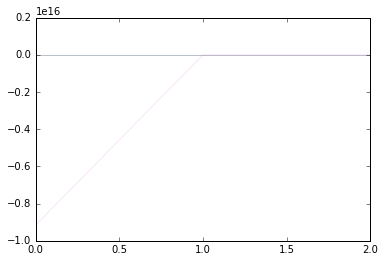

In [341]:
for i in range(len(eig_values[0])):    
    plt.plot(eig_values[:][i][0] / eig_values[:][i][2], alpha=0.1)

# np.vstack(eig_values[0])


# eig_values[0]

In [189]:
for cluster in np.unique(np.concatenate([gals_z6p42_mstar['z0_centralId'],
                                         gals_z5p03_mstar['z0_centralId'],
                                         gals_z3p95_mstar['z0_centralId'],
                                         gals_z3p10_mstar['z0_centralId'],
                                         gals_z2p07_mstar['z0_centralId']])):
    
    calc_eigs_inertia_single(gals_z6p42_mstar, cluster)
    
    coods = gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']].copy()

    if np.abs(coods['zn_x'].max() - coods['zn_x'].min()) > L/2:
        coods['zn_x'] = coods['zn_x'] - L
        coods['zn_x'].loc[coods['zn_x'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_x'][coods['zn_x'] < -L/2]

    if np.abs(coods['zn_y'].max() - coods['zn_y'].min()) > L/2:
        coods['zn_y'] = coods['zn_y'] - L
        coods['zn_y'].loc[coods['zn_y'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_y'][coods['zn_y'] < -L/2]

    if np.abs(coods['zn_z'].max() - coods['zn_z'].min()) > L/2:
        coods['zn_z'] = coods['zn_z'] - L
        coods['zn_z'].loc[coods['zn_z'] < -L/2] = gals[gals['z0_centralId'] == cluster]['zn_z'][coods['zn_z'] < -L/2]

    center = np.mean(coods)
    coods = coods - center

    I = np.zeros((3, 3))

    I[0,0] = np.sum(coods['zn_z']**2 + coods['zn_y']**2)
    I[1,1] = np.sum(coods['zn_z']**2 + coods['zn_x']**2)
    I[2,2] = np.sum(coods['zn_x']**2 + coods['zn_y']**2)

    I[0,1] = I[1,0] = - np.sum(coods['zn_x'] * coods['zn_y'])
    I[1,2] = I[2,1] = - np.sum(coods['zn_z'] * coods['zn_y'])
    I[0,2] = I[2,0] = - np.sum(coods['zn_z'] * coods['zn_x'])

    e_values, e_vectors = np.linalg.eig(I)


KeyboardInterrupt: 

In [113]:
eig_vals_z6p42_mstar9, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_mstar)
eig_vals_z5p03_mstar9, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_mstar)
eig_vals_z3p95_mstar9, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_mstar)
eig_vals_z3p10_mstar9, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_mstar)
eig_vals_z2p07_mstar9, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_mstar)

eig_vals_z6p42_sfr, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_sfr)
eig_vals_z5p03_sfr, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_sfr)
eig_vals_z3p95_sfr, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_sfr)
eig_vals_z3p10_sfr, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_sfr)
eig_vals_z2p07_sfr, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_sfr)

eig_vals_z6p42_mstar10, unresolved_z6p42 = calc_eigs_inertia(gals_z6p42_mstar.loc[gals_z6p42_mstar['zn_stellarMass'] > 1])
eig_vals_z5p03_mstar10, unresolved_z5p03 = calc_eigs_inertia(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1])
eig_vals_z3p95_mstar10, unresolved_z3p95 = calc_eigs_inertia(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1])
eig_vals_z3p10_mstar10, unresolved_z3p10 = calc_eigs_inertia(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1])
eig_vals_z2p07_mstar10, unresolved_z2p07 = calc_eigs_inertia(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1])

z0 shapes

In [ ]:
# z0 shapes
z0_gals_mstar10 = pd.read_csv('data/z0_central_gals_mstar10.csv', skiprows=22, skipfooter=1, engine='python')
z0_gals_mstar9 = pd.read_csv('data/z0_central_gals_mstar9.csv', skiprows=22, skipfooter=1, engine='python')
z0_gals_sfr = pd.read_csv('data/z0_central_gals_sfr.csv', skiprows=22, skipfooter=1, engine='python')

In [164]:

eig_values = [None] * 3

eig_values[0] = z0_eigs(z0_gals_mstar10)
eig_values[1] = z0_eigs(z0_gals_mstar9)
eig_values[2] = z0_eigs(z0_gals_sfr)

eig_values[2] = eig_values[2][~(eig_values[2][:,0] == 0.),:]

IndexError: too many indices for array

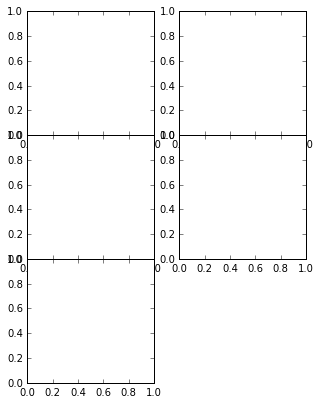

In [54]:
fig = plt.figure(figsize=(5,12))

gs = gridspec.GridSpec(3, 2)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

ls = ['solid','dashed','dotted']


## z0 shapes

for linestyle, eigs in zip(ls, eig_values):
    for ax in [ax1, ax2, ax3, ax4, ax5]:
    
        phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
        ax.step(bins, phi, c='grey', linestyle=linestyle)

        phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
        ax.step(bins, phi, c='grey', linestyle=linestyle)


## Plot 1

c1 = 'blue'
c2 = 'red'

for i, eigs in enumerate([eig_vals_z2p07_sfr, eig_vals_z2p07_mstar9, eig_vals_z2p07_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c2, linestyle=ls[i])



## Plot 2

for i, eigs in enumerate([eig_vals_z3p10_sfr, eig_vals_z3p10_mstar9, eig_vals_z3p10_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c2, linestyle=ls[i])


## Plot 3

for i, eigs in enumerate([eig_vals_z3p95_sfr, eig_vals_z3p95_mstar9, eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z5p03_sfr, eig_vals_z5p03_mstar9]): #, eig_vals_z5p03_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c2, linestyle=ls[i])


for i, eigs in enumerate([eig_vals_z6p42_sfr, eig_vals_z6p42_mstar9]): #, eig_vals_z6p42_mstar10]):
    phi, dummy = np.histogram(eigs[:,0] / eigs[:,2], bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c1, linestyle=ls[i])

    phi, dummy = np.histogram(eigs[:,1] / eigs[:,2], bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c2, linestyle=ls[i])



ax1.text(0.1, 0.85, "z = 2.07", transform = ax1.transAxes)
ax2.text(0.1, 0.85, "z = 3.10", transform = ax2.transAxes)
ax3.text(0.1, 0.85, "z = 3.95", transform = ax3.transAxes)
ax4.text(0.1, 0.85, "z = 5.03", transform = ax4.transAxes)
ax5.text(0.1, 0.85, "z = 6.42", transform = ax5.transAxes)

## Legend

sArtist = plt.Line2D((0,1),(0,0), color=c1)
qArtist = plt.Line2D((0,1),(0,0), color=c2)
Artist0 = plt.Line2D((0,1),(0,0), color='grey')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[sArtist, qArtist, Artist0, sfrArtist, mstar9Artist, mstar10Artist], 
           labels=['$s = a / c$','$q = b / c$','$z=0$',
                   '$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{9}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, -0.14), prop={'size':11}, frameon=False)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax4.set_xticklabels([])

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_yticklabels(['','1','2','3','4','5'])
    
ax3.set_xlabel('Axis ratio')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/ax_ratios.png', bbox_inches='tight', dpi=300)

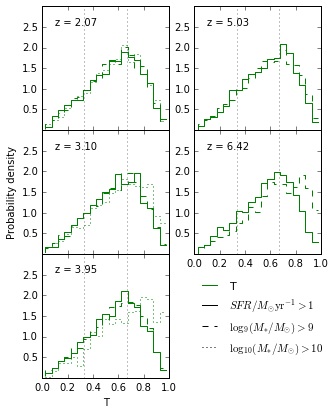

In [166]:
fig = plt.figure(figsize=(5,12))

gs = gridspec.GridSpec(3, 2)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)


## Plot 1

ls = ['solid','dashed','dotted']

c1 = 'green'

for i, eigs in enumerate([eig_vals_z2p07_sfr, eig_vals_z2p07_mstar9, eig_vals_z2p07_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax1.step(bins,phi, color=c1, linestyle=ls[i])


# ax1.set_ylim(0, 5)

## Plot 2

for i, eigs in enumerate([eig_vals_z3p10_sfr, eig_vals_z3p10_mstar9, eig_vals_z3p10_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax2.step(bins,phi, color=c1, linestyle=ls[i])

# ax2.set_ylim(0, 5)

## Plot 3

for i, eigs in enumerate([eig_vals_z3p95_sfr, eig_vals_z3p95_mstar9, eig_vals_z3p95_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax3.step(bins,phi, color=c1, linestyle=ls[i])

# ax3.set_ylim(0, 5)

for i, eigs in enumerate([eig_vals_z5p03_sfr, eig_vals_z5p03_mstar9]): #, eig_vals_z5p03_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax4.step(bins,phi, color=c1, linestyle=ls[i])

# ax4.set_ylim(0, 5)

for i, eigs in enumerate([eig_vals_z6p42_sfr, eig_vals_z6p42_mstar9]): #, eig_vals_z6p42_mstar10]):
    phi, dummy = np.histogram((eigs[:,0]**2 - eigs[:,1]**2) / (eigs[:,0]**2 - eigs[:,2]**2), bins=binLimits, normed=True)
    ax5.step(bins,phi, color=c1, linestyle=ls[i])
    

# ax5.set_ylim(0, 5)

ax1.text(0.1, 0.85, "z = 2.07", transform = ax1.transAxes)
ax2.text(0.1, 0.85, "z = 3.10", transform = ax2.transAxes)
ax3.text(0.1, 0.85, "z = 3.95", transform = ax3.transAxes)
ax4.text(0.1, 0.85, "z = 5.03", transform = ax4.transAxes)
ax5.text(0.1, 0.85, "z = 6.42", transform = ax5.transAxes)

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.vlines(1./3, 0, 3, linestyles='dotted', colors='grey')
    ax.vlines(2./3, 0, 3, linestyles='dotted', colors='grey')

## Legend

tArtist = plt.Line2D((0,1),(0,0), color=c1)

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[tArtist, sfrArtist, mstar9Artist, mstar10Artist], 
           labels=['T','$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{9}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, -0.14), prop={'size':11}, frameon=False)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax4.set_xticklabels([])

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_yticklabels(['','0.5','1.0','1.5','2.0','2.5',''])
    
ax3.set_xlabel('T')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/triax_param.png', bbox_inches='tight', dpi=300)

3D plot of protocluster member galaxies and principal axes

NameError: name 'coods' is not defined

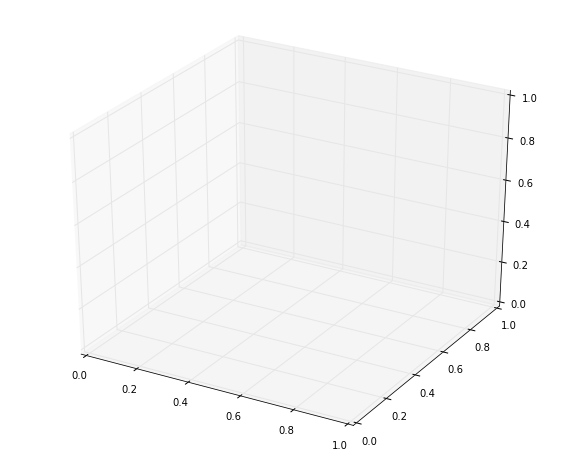

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(coods['zn_x'],
           coods['zn_y'],
           zs=coods['zn_z'])
#             ,c = gals[gals['z0_centralId'] == cluster]['delta_gal_20'],
#           cmap='viridis')

# fig.colorbar(p)

cols = ['r','b','g']

for j in range(len(e_vectors)):
    print e_vectors[j]
    
    e_components = e_vectors[j] * e_values[j] / 150

    ax.plot([0, e_components[0]], 
             [0, e_components[1]], 
             [0, e_components[2]], c=cols[j])

ax.view_init(30, 10)



#### z = 0 cluster galaxy distributions

*select
x, y, z,        
haloId, fofSubHaloId, stellarMass, sfr, snapnum, centralMvir       
from          
henriques2015a..MRscPlanck1          
where          
snapnum=58   
and centralMvir >= 1e4 and stellarMass > 0.1*